<a href="https://colab.research.google.com/github/SirvavialTAG/MachineLearning/blob/main/Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# МЛ Практика 3: Подбор признаков и валидация моделей

## **Цель занятия:**
Изучить методы поиска значимых признаков в данных. На практике мы проведем анализ целевой переменной **Y**, применим методы для поиска значимых признаков, обучим линейную модель, проанализируем результат и оценим валидность модели.

## **Задание состоит из следующих частей:**
1. Обработка выбросов;
1. Поиск значимых признаков с использованием библиотеки **sklearn**.
2. Обучение логистической регресси модели и оценка ее точности.
6. Кросс-валидация с использованием разных методов (K-fold, ShuffleSplit, test-train-validation)

## 1: Загрузка библиотек и предобратка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel

In [2]:
# Загрузка набора данных
df = pd.read_csv('bank.csv')

In [3]:
# Вывод набора
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  deposit    45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [5]:
df['has_deposit'] = np.where(df['deposit'] == 'yes', 1, 0)
df.has_deposit = df.has_deposit.astype('category')

# Переводим столбцы с типом данных 'object' в тип данных 'category'
for col in df.columns:
  if df[col].dtype == 'object':
    df[col] = df[col].astype('category')

In [6]:
Y = df['has_deposit'] # выбираем целевую переменную (категориальную)
X = df.drop('has_deposit', axis=1) # переменные для проверки влияния на целевую переменную

X = X.drop('deposit', axis=1) # Дроп базовой переменной

In [7]:
df.drop('deposit', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   age          45211 non-null  int64   
 1   job          45211 non-null  category
 2   marital      45211 non-null  category
 3   education    45211 non-null  category
 4   default      45211 non-null  category
 5   balance      45211 non-null  int64   
 6   housing      45211 non-null  category
 7   loan         45211 non-null  category
 8   contact      45211 non-null  category
 9   day          45211 non-null  int64   
 10  month        45211 non-null  category
 11  duration     45211 non-null  int64   
 12  campaign     45211 non-null  int64   
 13  pdays        45211 non-null  int64   
 14  previous     45211 non-null  int64   
 15  poutcome     45211 non-null  category
 16  has_deposit  45211 non-null  category
dtypes: category(10), int64(7)
memory usage: 2.8 MB


In [8]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,has_deposit
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes,1
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes,1
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes,1
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no,0


## 2: масштабирование признаков

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        45211 non-null  int64   
 1   job        45211 non-null  category
 2   marital    45211 non-null  category
 3   education  45211 non-null  category
 4   default    45211 non-null  category
 5   balance    45211 non-null  int64   
 6   housing    45211 non-null  category
 7   loan       45211 non-null  category
 8   contact    45211 non-null  category
 9   day        45211 non-null  int64   
 10  month      45211 non-null  category
 11  duration   45211 non-null  int64   
 12  campaign   45211 non-null  int64   
 13  pdays      45211 non-null  int64   
 14  previous   45211 non-null  int64   
 15  poutcome   45211 non-null  category
dtypes: category(9), int64(7)
memory usage: 2.8 MB


In [10]:
# Создаем копию данных
X_processed = X.copy()

category_columns: list[str] = X_processed.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X_processed = pd.get_dummies(X_processed, columns=category_columns,drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.

In [11]:
X_processed

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,5,261,1,-1,0,False,False,False,...,False,False,False,True,False,False,False,False,False,True
1,44,29,5,151,1,-1,0,False,False,False,...,False,False,False,True,False,False,False,False,False,True
2,33,2,5,76,1,-1,0,False,True,False,...,False,False,False,True,False,False,False,False,False,True
3,47,1506,5,92,1,-1,0,True,False,False,...,False,False,False,True,False,False,False,False,False,True
4,33,1,5,198,1,-1,0,False,False,False,...,False,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,825,17,977,3,-1,0,False,False,False,...,False,False,False,False,True,False,False,False,False,True
45207,71,1729,17,456,2,-1,0,False,False,False,...,False,False,False,False,True,False,False,False,False,True
45208,72,5715,17,1127,5,184,3,False,False,False,...,False,False,False,False,True,False,False,False,True,False
45209,57,668,17,508,4,-1,0,True,False,False,...,False,False,False,False,True,False,False,False,False,True


In [12]:
# Выбираем числовые признаки
numeric_features = X_processed.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
X_processed[numeric_features] = scaler.fit_transform(X_processed[numeric_features])

In [13]:
X_processed

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,0.519481,0.092259,0.133333,0.053070,0.000000,0.000000,0.000000,False,False,False,...,False,False,False,True,False,False,False,False,False,True
1,0.337662,0.073067,0.133333,0.030704,0.000000,0.000000,0.000000,False,False,False,...,False,False,False,True,False,False,False,False,False,True
2,0.194805,0.072822,0.133333,0.015453,0.000000,0.000000,0.000000,False,True,False,...,False,False,False,True,False,False,False,False,False,True
3,0.376623,0.086476,0.133333,0.018707,0.000000,0.000000,0.000000,True,False,False,...,False,False,False,True,False,False,False,False,False,True
4,0.194805,0.072812,0.133333,0.040260,0.000000,0.000000,0.000000,False,False,False,...,False,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,0.428571,0.080293,0.533333,0.198658,0.032258,0.000000,0.000000,False,False,False,...,False,False,False,False,True,False,False,False,False,True
45207,0.688312,0.088501,0.533333,0.092721,0.016129,0.000000,0.000000,False,False,False,...,False,False,False,False,True,False,False,False,False,True
45208,0.701299,0.124689,0.533333,0.229158,0.064516,0.212156,0.010909,False,False,False,...,False,False,False,False,True,False,False,False,True,False
45209,0.506494,0.078868,0.533333,0.103294,0.048387,0.000000,0.000000,True,False,False,...,False,False,False,False,True,False,False,False,False,True


## 3: Очистка данных и удаление выбросов

Важным шагом в машинном обучении - является очистка и удаление данных от выбросов.

### Методы обработки выбросов:

1. **Метод на основе медианы и межквартильного размаха (IQR)**:
   - **Как работает**:
     Метод основан на расчете межквартильного размаха (IQR), который вычисляется как разница между третьим (75-й перцентиль) и первым квартилем (25-й перцентиль). Данные считаются выбросами, если они выходят за пределы диапазона \([Q1 - 1.5 * IQR , Q3 + 1.5 * IQR]\).
   - **Зачем это нужно**:
     Выбросы могут серьезно искажать результаты моделей, особенно тех, которые основаны на средних значениях или предполагают нормальное распределение данных.
   - **Когда лучше использовать**:
     - Когда данные содержат **немного выбросов** и имеют **асимметричное распределение**.
     - Метод медианы и IQR более устойчив к выбросам по сравнению с методом, основанным на среднем значении, так как медиана меньше подвержена влиянию экстремальных значений.
     - Хорошо подходит для набора данных, которые не распределены нормально (например, зарплаты или цены на недвижимость).

2. **Метод на основе среднего (Mean)**:
   - **Как работает**:
     Метод использует средние значения и удаляет те признаки или записи, которые значительно отклоняются от среднего. Чаще всего это делается с помощью установления порога (например, данные, которые превышают 2 или 3 средних значения, считаются выбросами).
   - **Зачем это нужно**:
     Выбросы, сильно отличающиеся от средних значений, могут существенно влиять на такие модели, как линейная регрессия, так как среднее значение сильно чувствительно к экстремальным точкам.
   - **Когда лучше использовать**:
     - Когда данные имеют **нормальное распределение** или приближены к нормальному.
     - Подходит, если данные содержат **много выбросов**, и вам нужно жестче ограничить их влияние на модель.

### Как выбрать метод:

- **Если данные асимметричны** или распределены с "хвостами" (например, распределение доходов или цен), лучше использовать **метод на основе медианы и IQR**, так как медиана не чувствительна к выбросам и лучше описывает такие наборы данных.
  
- **Если данные нормально распределены** и важно учитывать всю выборку, даже если есть выбросы, можно использовать **метод на основе среднего**. Этот метод будет точнее отражать центр распределения в симметричных данных и позволит выявить значительные отклонения от него.

Оба метода помогают улучшить производительность моделей машинного обучения, обеспечивая более точное представление данных для анализа и обучения.

### Для начала определим функцию обучения с оценкой качества (для простоты)

In [14]:
from sklearn.model_selection import cross_val_score

def train_and_evaluate(X, Y):
    # Разделение данных на обучающую и тестовую выборки
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42, stratify=Y)

    # Инициализация модели
    model = LogisticRegression(max_iter=1000)

    # Обучение модели
    model.fit(X_train, Y_train)

    # Предсказания на обучающей выборке
    Y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(Y_train, Y_train_pred)

    # Предсказания на тестовой выборке
    Y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(Y_test, Y_test_pred)

    # Вывод результатов
    print(f"Точность на обучающей выборке: {train_accuracy:.4f}")
    print(f"Точность на тестовой выборке: {test_accuracy:.4f}")

    # Классификационный отчет
    print("\nКлассификационный отчет на тестовой выборке:")
    print(classification_report(Y_test, Y_test_pred))

    return model

In [15]:
train_and_evaluate(X_processed, Y)

Точность на обучающей выборке: 0.9019
Точность на тестовой выборке: 0.9003

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7985
           1       0.65      0.32      0.43      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.65      0.69      9043
weighted avg       0.88      0.90      0.89      9043



LogisticRegression(max_iter=1000)

### Метод 1: удаление на основе медианы

In [18]:
# Функция для удаления выбросов на основе межквартильного размаха (1.5 IQR)
def remove_outliers_based_on_iqr(X, Y, iqr_multiplier=1.5):
    # Убедимся, что работаем только с числовыми данными
    X_numeric = X.select_dtypes(include=['number'])

    # Рассчитываем первый и третий квартили для каждой числовой переменной
    Q1 = X_numeric.quantile(0.25)
    Q3 = X_numeric.quantile(0.75)

    # Вычисляем межквартильный размах (IQR)
    IQR = Q3 - Q1

    # Оставляем только те значения, которые находятся в диапазоне [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
    X_filtered = X_numeric[~((X_numeric < (Q1 - iqr_multiplier * IQR)) | (X_numeric > (Q3 + iqr_multiplier * IQR))).any(axis=1)]

    # Синхронизируем y с отфильтрованными X
    Y_filtered = Y.loc[X_filtered.index]

    return X_filtered, Y_filtered

In [19]:
X_iqr, y_iqr = remove_outliers_based_on_iqr(X_processed, Y, iqr_multiplier=1.5)

In [20]:
X_processed.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,0.297873,0.085171,0.493547,0.052494,0.028449,0.047245,0.002110
std,0.137906,0.027643,0.277416,0.052364,0.049968,0.114827,0.008376
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.194805,0.073457,0.233333,0.020943,0.000000,0.000000,0.000000
50%,0.272727,0.076871,0.500000,0.036600,0.016129,0.000000,0.000000
75%,0.389610,0.085768,0.666667,0.064864,0.032258,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
X_iqr.describe()

,age,balance,day,duration,campaign,pdays,previous
count,28192.000000,28192.000000,28192.000000,28192.000000,28192.000000,28192.0,28192.0
mean,0.290558,0.078310,0.492511,0.041757,0.019189,0.0,0.0
std,0.128363,0.007552,0.278558,0.028329,0.021640,0.0,0.0
min,0.000000,0.055154,0.000000,0.000000,0.000000,0.0,0.0
25%,0.181818,0.073085,0.233333,0.020537,0.000000,0.0,0.0
50%,0.272727,0.075677,0.500000,0.034364,0.016129,0.0,0.0
75%,0.389610,0.081156,0.700000,0.056324,0.032258,0.0,0.0
max,0.675325,0.104225,1.000000,0.130744,0.080645,0.0,0.0


In [22]:
train_and_evaluate(X_iqr, y_iqr)

Точность на обучающей выборке: 0.9433
Точность на тестовой выборке: 0.9433

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5319
           1       0.00      0.00      0.00       320

    accuracy                           0.94      5639
   macro avg       0.47      0.50      0.49      5639
weighted avg       0.89      0.94      0.92      5639



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LogisticRegression(max_iter=1000)

**Вывод**
* При использовании метода обработки выбросов на основе медианы и межквартильного размаха «срезалось» **37 %** данных, что является существенным сокращением и может сказаться на точности работы модели
* Среднее значение некоторых переменных немного уменьшилось, что может указывать на то, что были удалены экстремально высокие значения (выбросы), которые сильно искажали распределение, однако сильно пострадали данные признаков **«pdays»** и **«previous»**, что может негативно повлиять на работу модели.
* Уменьшение стандартного отклонения признаков может быть показателем того, что данные стали более концентрированными вокруг медианы, и разброс значений стал меньше. Это может улучшить стабильность модели и уменьшить влияние выбросов.
* Точность на обучающей **(от 0.9019 до 0.9433)** и тестовой **(от 0.9003 до 0.9433)** выборке существенно увеличилась, несмотря на возможную значительную потерю полезной информации.

### Метод 2: удаление на основе среднего

In [23]:
# Функция для удаления выбросов на основе среднего значения
def remove_outliers_based_on_mean(X, Y, mean_multiplier=2):
    # Убедимся, что работаем только с числовыми данными
    X_numeric = X.select_dtypes(include=['number'])

    # Рассчитываем среднее значение и стандартное отклонение для каждой переменной
    mean_values = X_numeric.mean()
    std_values = X_numeric.std()

    # Устанавливаем верхний и нижний пороги на основе среднего значения и множителя стандартного отклонения
    lower_threshold = mean_values - mean_multiplier * std_values
    upper_threshold = mean_values + mean_multiplier * std_values

    # Фильтруем наблюдения, которые находятся в пределах этих порогов по всем признакам
    X_filtered = X_numeric[~((X_numeric < lower_threshold) | (X_numeric > upper_threshold)).any(axis=1)]

    # Синхронизируем y с отфильтрованными X
    Y_filtered = Y.loc[X_filtered.index]

    return X_filtered, Y_filtered

In [24]:
X_mean, y_mean = remove_outliers_based_on_mean(X_processed.copy(), Y.copy())

In [25]:
X_processed.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,0.297873,0.085171,0.493547,0.052494,0.028449,0.047245,0.002110
std,0.137906,0.027643,0.277416,0.052364,0.049968,0.114827,0.008376
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.194805,0.073457,0.233333,0.020943,0.000000,0.000000,0.000000
50%,0.272727,0.076871,0.500000,0.036600,0.016129,0.000000,0.000000
75%,0.389610,0.085768,0.666667,0.064864,0.032258,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
X_mean.describe()

,age,balance,day,duration,campaign,pdays,previous
count,35293.000000,35293.000000,35293.000000,35293.000000,35293.000000,35293.000000,35293.000000
mean,0.290287,0.081406,0.495802,0.044478,0.021180,0.015429,0.000777
std,0.125790,0.012909,0.278430,0.032513,0.025744,0.051074,0.002773
min,0.025974,0.035970,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.181818,0.073321,0.233333,0.020740,0.000000,0.000000,0.000000
50%,0.272727,0.076435,0.500000,0.035177,0.016129,0.000000,0.000000
75%,0.389610,0.084197,0.666667,0.059374,0.032258,0.000000,0.000000
max,0.571429,0.140450,1.000000,0.157178,0.112903,0.276376,0.018182


In [27]:
train_and_evaluate(X_mean, y_mean)

Точность на обучающей выборке: 0.9151
Точность на тестовой выборке: 0.9161

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      6463
           1       0.54      0.04      0.08       596

    accuracy                           0.92      7059
   macro avg       0.73      0.52      0.52      7059
weighted avg       0.89      0.92      0.88      7059



LogisticRegression(max_iter=1000)

**Вывод**
* При использовании метода обработки выбросов на основе среднего «срезалось» **22 %** данных, что меньше, чем у метода обработки выбросов на основе медианы и межквартильного размаха.
* Среднее значение признаков немного уменьшилось, что может указывать на то, что были удалены экстремально высокие значения (выбросы), которые сильно искажали распределение. При использовании этого метода данные признаков **«pdays»** и **«previous»** были не сильно «срезаны», что является хорошим знаком, так как эти данные могут влиять на конечный результат модели.
* Уменьшение стандартного отклонения признаков может быть показателем того, что данные стали более концентрированными вокруг медианы, и разброс значений стал меньше. Это может улучшить стабильность модели и уменьшить влияние выбросов.
* Точность на обучающей **(от 0.9019 до 0.9151)** и тестовой **(от 0.9003 до 0.9161)** выборке немного увеличилась.

## 4: Методы отбора признаков

Отбор признаков (feature selection) — важный шаг в машинном обучении, который помогает улучшить качество моделей и ускорить их работу. Цель отбора — убрать лишние или малозначимые признаки, которые не влияют на предсказания модели, либо могут ухудшить её производительность.

Зачем это нужно:
1. **Улучшение производительности модели** — избыточные признаки могут создавать шум и снижать точность.
2. **Повышение интерпретируемости** — меньший набор признаков легче анализировать и объяснять.
3. **Снижение вычислительной сложности** — меньшее количество признаков ускоряет обучение и предсказание.

В sklearn основные методы отбора признаков включают:
1. **Filter методы** — основаны на статистических тестах, например, `SelectKBest` использует критерий, чтобы выбрать признаки с наибольшим вкладом.
2. **Wrapper методы** — оценивают модели на разных подмножествах признаков, например, рекурсивное исключение признаков (`RFE`).
3. **Embedded методы** — выполняют отбор признаков во время обучения модели, например, с помощью L1-регуляризации (Lasso).

### Filter методы

Filter методы основаны на статистических свойствах данных и выбирают признаки, не учитывая алгоритм машинного обучения. Они работают как предварительный шаг перед обучением модели и быстро отбирают наиболее информативные признаки.

Преимущества:

- Быстро выполняются.
- Не зависят от модели.
- Уменьшают размерность данных до обучения.

Недостатки:

- Не учитывают взаимодействие между признаками.
- Могут упускать важные комбинации признаков.

In [28]:
from sklearn.feature_selection import SelectKBest, f_classif

In [58]:
# Применяем SelectKBest для выбора 5 лучших признаков
selector = SelectKBest(score_func=f_classif, k=8) # Используем f_classif, так как задача типа классификации
X_kbest = selector.fit_transform(X_processed, Y)

In [59]:
selector.scores_

array([2.86252331e+01, 1.26572276e+02, 3.63590097e+01, 8.33376115e+03,
       2.43358404e+02, 4.90696563e+02, 3.96443989e+02, 2.36131946e+02,
       1.74848496e+01, 1.04404413e+01, 4.90437055e+01, 2.85698413e+02,
       3.30512931e-02, 3.51275260e+01, 2.68917823e+02, 3.63769975e+00,
       1.88034092e+01, 3.21682913e-03, 1.64766391e+02, 1.83181227e+02,
       5.99391070e+01, 2.00499806e+02, 6.56884906e+00, 2.27339232e+01,
       8.92950576e+02, 2.11167395e+02, 8.91656675e+00, 1.05393278e+03,
       3.29453476e+00, 2.56868313e+02, 6.68217983e+01, 3.48738562e+00,
       5.35042942e+01, 1.27705073e+01, 7.70566237e+02, 4.80019957e+02,
       1.00892971e+01, 7.59412860e+02, 6.96599372e+02, 4.62111243e+01,
       4.69711384e+03, 1.29781589e+03])

In [60]:
X_processed.columns

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'education_secondary',
       'education_tertiary', 'education_unknown', 'default_yes', 'housing_yes',
       'loan_yes', 'contact_telephone', 'contact_unknown', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown'],
      dtype='object')

In [61]:
X_processed

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,0.519481,0.092259,0.133333,0.053070,0.000000,0.000000,0.000000,False,False,False,...,False,False,False,True,False,False,False,False,False,True
1,0.337662,0.073067,0.133333,0.030704,0.000000,0.000000,0.000000,False,False,False,...,False,False,False,True,False,False,False,False,False,True
2,0.194805,0.072822,0.133333,0.015453,0.000000,0.000000,0.000000,False,True,False,...,False,False,False,True,False,False,False,False,False,True
3,0.376623,0.086476,0.133333,0.018707,0.000000,0.000000,0.000000,True,False,False,...,False,False,False,True,False,False,False,False,False,True
4,0.194805,0.072812,0.133333,0.040260,0.000000,0.000000,0.000000,False,False,False,...,False,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,0.428571,0.080293,0.533333,0.198658,0.032258,0.000000,0.000000,False,False,False,...,False,False,False,False,True,False,False,False,False,True
45207,0.688312,0.088501,0.533333,0.092721,0.016129,0.000000,0.000000,False,False,False,...,False,False,False,False,True,False,False,False,False,True
45208,0.701299,0.124689,0.533333,0.229158,0.064516,0.212156,0.010909,False,False,False,...,False,False,False,False,True,False,False,False,True,False
45209,0.506494,0.078868,0.533333,0.103294,0.048387,0.000000,0.000000,True,False,False,...,False,False,False,False,True,False,False,False,False,True


In [62]:
selector.get_support(indices=True)

array([ 3, 24, 27, 34, 37, 38, 40, 41])

In [63]:
# Получаем список отобранных признаков
selected_features = X_processed.columns[selector.get_support(indices=True)]
print("Отобранные признаки:", selected_features)

Отобранные признаки: Index(['duration', 'housing_yes', 'contact_unknown', 'month_mar', 'month_oct',
       'month_sep', 'poutcome_success', 'poutcome_unknown'],
      dtype='object')


In [64]:
# Преобразуем X_kbest в DataFrame
X_kbest_df = pd.DataFrame(X_kbest, columns=selected_features)

# Обучаем и оцениваем модель
train_and_evaluate(X_kbest_df, Y)

Точность на обучающей выборке: 0.9016
Точность на тестовой выборке: 0.9011

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      7985
           1       0.67      0.31      0.42      1058

    accuracy                           0.90      9043
   macro avg       0.79      0.65      0.69      9043
weighted avg       0.89      0.90      0.88      9043



LogisticRegression(max_iter=1000)

### Wrapper методы

Wrapper методы оценивают различные комбинации признаков, обучая модель на каждом подмножестве, и выбирают набор признаков, который дает наилучшее качество модели. Они учитывают взаимодействия между признаками, но могут быть вычислительно затратными.

Преимущества:

- Учитывают взаимодействия между признаками.
- Могут улучшить производительность модели.

Недостатки:

- Высокая вычислительная сложность.
- Длительное время выполнения на больших наборах данных.

In [65]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Инициализируем модель логистической регрессии
base_model = LogisticRegression(max_iter=1000)

# Инициализируем RFE для выбора 5 лучших признаков
rfe = RFE(estimator=base_model, n_features_to_select=8)
rfe.fit(X_processed, Y)

# Получаем список отобранных признаков
selected_features = X_processed.columns[rfe.support_]
print("Отобранные признаки:", selected_features)

Отобранные признаки: Index(['balance', 'duration', 'campaign', 'month_dec', 'month_mar',
       'month_oct', 'month_sep', 'poutcome_success'],
      dtype='object')


In [66]:
# Отбираем признаки
X_rfe = X_processed[selected_features]

# Обучаем и оцениваем модель
model = train_and_evaluate(X_rfe, Y)

Точность на обучающей выборке: 0.8998
Точность на тестовой выборке: 0.8985

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7985
           1       0.66      0.27      0.39      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.63      0.67      9043
weighted avg       0.88      0.90      0.88      9043



### Embedded методы

Преимущества:

Учитывают взаимодействия между признаками.
- Менее вычислительно затратны, чем Wrapper методы.
- Интегрированы в процесс обучения.

Недостатки:

- Зависимы от выбранной модели.
- Могут не отбирать признаки, важные для других моделей.

Коэффициенты модели без регуляризации: [[ 6.22031862e-03  1.02835503e+00  2.47789182e-01  1.86977010e+01
  -3.84918088e+00 -2.58523486e-02  2.45880775e-01 -2.91843277e-01
  -3.43803972e-01 -4.56287315e-01 -1.55680972e-01  2.65903166e-01
  -2.78880150e-01 -2.22811105e-01  3.68868256e-01 -1.72148940e-01
  -1.47013258e-01 -3.01880187e-01 -1.69094782e-01  1.00920364e-01
   1.88381258e-01  3.80826484e-01  2.57505907e-01 -4.09181027e-02
  -6.48232590e-01 -4.17954604e-01 -1.75040174e-01 -1.55037580e+00
  -7.04904313e-01  7.61798448e-01 -1.59228870e-01 -1.18580147e+00
  -8.02426171e-01  4.12626297e-01  1.52080947e+00 -3.95898261e-01
  -8.30523504e-01  8.70384806e-01  8.52572136e-01  2.08065394e-01
   2.25248940e+00 -1.01844557e-01]]
Коэффициенты модели с регуляризацией: [[ 0.00000000e+00  1.07046111e+00  2.77163139e-01  2.04789147e+01
  -5.21311057e+00 -4.62645073e-02  0.00000000e+00 -2.97410614e-01
  -3.29010612e-01 -4.75584940e-01 -1.41758558e-01  2.67376798e-01
  -2.69377996e-01 -2.06572214

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Коэффициенты модели после отбора признаков: [[ 1.05711521e+00  2.75659979e-01  2.04754609e+01 -5.21233900e+00
  -5.75271869e-02 -2.98930120e-01 -3.30175966e-01 -4.77642300e-01
  -1.42739782e-01  2.65468994e-01 -2.70427621e-01 -2.07650101e-01
   3.91409374e-01 -1.57804788e-01 -1.51972382e-01 -2.45975795e-01
  -1.83026711e-01  8.80932450e-02  1.68606301e-01  3.59619400e-01
   2.26527171e-01 -3.74053275e-04 -6.76563943e-01 -4.25336905e-01
  -1.58593848e-01 -1.61023358e+00 -7.04131205e-01  6.56942115e-01
  -1.55520475e-01 -1.24569526e+00 -8.34584087e-01  4.34891670e-01
   1.57020051e+00 -4.05725865e-01 -8.67574167e-01  8.73537296e-01
   8.56033811e-01  2.02372221e-01  2.28353920e+00 -1.22015921e-01]]


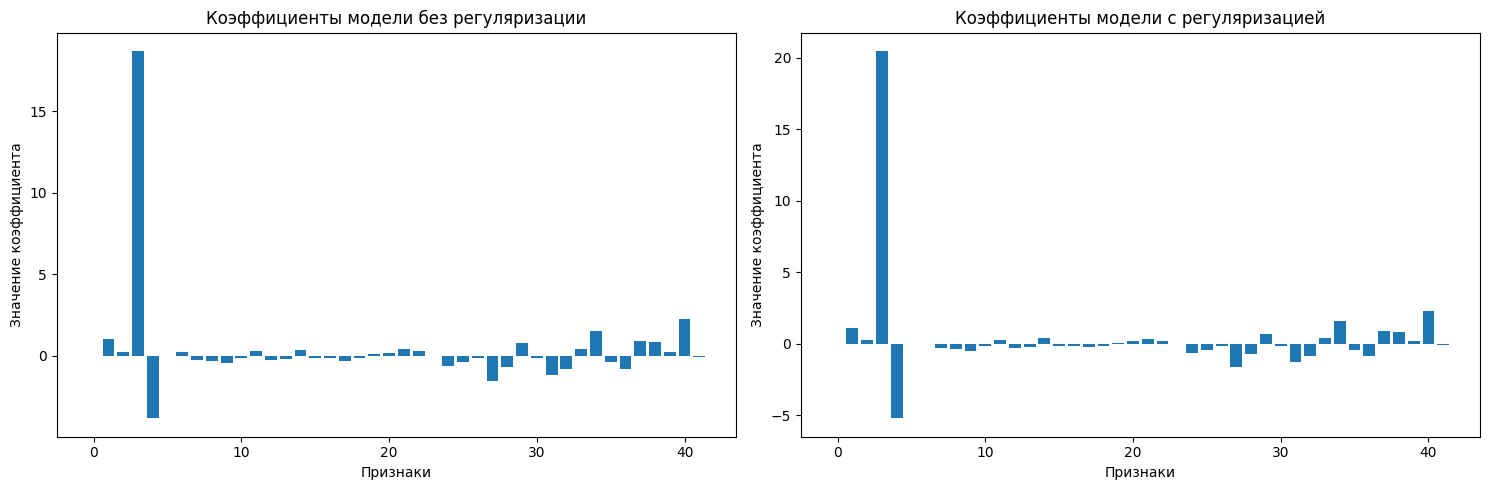

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import numpy as np
import matplotlib.pyplot as plt

# Обучаем модель без регуляризации
model_no_penalty = LogisticRegression(solver='lbfgs', max_iter=1000)
model_no_penalty.fit(X_processed, Y)

# Выводим коэффициенты модели без регуляризации
coefficients_no_penalty = model_no_penalty.coef_
print("Коэффициенты модели без регуляризации:", coefficients_no_penalty)

# Инициализируем модель с L1-регуляризацией
model_with_penalty = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

# Обучаем модель с регуляризацией
model_with_penalty.fit(X_processed, Y)

# Выводим коэффициенты модели с регуляризацией
coefficients_with_penalty = model_with_penalty.coef_
print("Коэффициенты модели с регуляризацией:", coefficients_with_penalty)

# Используем SelectFromModel для отбора признаков
selector = SelectFromModel(model_with_penalty, prefit=True)
X_embedded = selector.transform(X_processed)

# Получаем список отобранных признаков
selected_features = X_processed.columns[selector.get_support()]
print("Отобранные признаки:", selected_features)

# Обучаем модель на отобранных признаках
model_embedded = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
model_embedded.fit(X_embedded, Y)

# Выводим коэффициенты модели после отбора признаков
coefficients_embedded = model_embedded.coef_
print("Коэффициенты модели после отбора признаков:", coefficients_embedded)

# Визуализация коэффициентов моделей
plt.figure(figsize=(15, 5))

# Коэффициенты модели без регуляризации
plt.subplot(1, 2, 1)
plt.bar(range(len(coefficients_no_penalty[0])), coefficients_no_penalty[0])
plt.title("Коэффициенты модели без регуляризации")
plt.xlabel("Признаки")
plt.ylabel("Значение коэффициента")

# Коэффициенты модели с регуляризацией
plt.subplot(1, 2, 2)
plt.bar(range(len(coefficients_with_penalty[0])), coefficients_with_penalty[0])
plt.title("Коэффициенты модели с регуляризацией")
plt.xlabel("Признаки")
plt.ylabel("Значение коэффициента")

plt.tight_layout()
plt.show()

In [39]:
# Преобразуем X_embedded в DataFrame
X_embedded_df = pd.DataFrame(X_embedded, columns=selected_features)

# Обучаем и оцениваем модель
model = train_and_evaluate(X_embedded_df, Y)

Точность на обучающей выборке: 0.9019
Точность на тестовой выборке: 0.8999

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7985
           1       0.64      0.32      0.43      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.65      0.69      9043
weighted avg       0.88      0.90      0.88      9043



**Вывод**

Было принято решение протестировать работу модели с параметром k=8. Ниже представлены результаты по точности на обучающей и тестовой выборках:

1. Filter метод:

* Точность на обучающей выборке: 0.9016
* Точность на тестовой выборке: 0.9011

2. Wrapper метод:

* Точность на обучающей выборке: 0.8998
* Точность на тестовой выборке: 0.8985

3. Embedded метод:

* Точность на обучающей выборке: 0.9019
* Точность на тестовой выборке: 0.8999

**Итог:**

Embedded метод показал наилучшие результаты по точности, незначительно превзойдя filter метод и заметно опередив wrapper метод. Скорее всего, это может быть связано с тем, что embedded методы учитывают взаимодействие между признаками, что важно для определения наличия вклада у клиента.

Поэтому для данной задачи рекомендуется использовать embedded метод отбора признаков.

# Метод отбора **SequentialFeatureSelector**


**SequentialFeatureSelector** — это метод отбора признаков, основанный на жадном алгоритме, который итеративно добавляет или удаляет признаки из модели, оценивая ее производительность на каждом шаге.

**Основные разновидности SequentialFeatureSelector:**

**1. Forward Selection:** Алгоритм начинает с пустого набора признаков. На каждой итерации он добавляет по одному признаку, оценивая производительность модели и выбирая признак с наибольшим улучшением. Процесс повторяется до достижения заданного количества признаков или пока добавление признаков не улучшает производительность значительно.

**2. Backward Elimination:** Алгоритм начинает со всех признаков. На каждой итерации он оценивает производительность модели, удаляя по одному признаку, и выбирает тот, удаление которого приводит к наименьшему ухудшению (или даже улучшению) производительности. Процесс повторяется до достижения заданного количества признаков или пока дальнейшее удаление признаков существенно не ухудшает производительность.

**Преимущества:**

1. Простота и интерпретируемость
2. Универсальность

**Недостатки**

1. Жадность
2. Вычислительная сложность

## Логистическая регрессия

**Логистическая регрессия** — это модель для задач бинарной классификации, которая предсказывает вероятность того, что наблюдение принадлежит к одному из двух классов (например, 0 или 1). Модель основана на линейной регрессии, но использует **сигмоидную функцию активации** для приведения предсказаний в диапазон от 0 до 1. Логистическая регрессия идеально подходит для задач, где нужно классифицировать данные на два класса.


#### Принцип работы логистической регрессии:
1. Сначала вычисляется линейная комбинация признаков с весами:  
y = b + w1 * x1 + w2 * x2 + w(n) * x(n), где

x - переменные

w - веса (коэфициенты регрессии)

b - смещение

Затем результат линейной комбинации передается в сигмоидную функцию активации, которая преобразует результат в значение от 0 до 1.

### Функция активации (Сигмоида)
**Сигмоидная функция** в логистической регрессии используется для преобразования линейной комбинации признаков в вероятность, что наблюдение относится к классу 1. Формула сигмоиды:

sigmoida = 1 / (1 + e^-y)

Она всегда возвращает значение в диапазоне от 0 до 1, что удобно для интерпретации как вероятность принадлежности к классу 1.

**Принцип работы:**
1. Инициализация весов: Изначально все веса устанавливаются в нули.

2. Градиентный спуск: На каждой итерации:
- Вычисляется линейная комбинация признаков.
- Применяется сигмоидная функция для предсказания вероятностей.
- Градиенты вычисляются для обновления весов и смещения, минимизируя ошибку.

3. Предсказание: Для новых данных модель возвращает вероятность, которая затем конвертируется в классы 0 или 1.

In [40]:
import numpy as np

# Сигмоидная функция
def sigmoid(z):
    # Убедимся, что z это numpy массив
    return 1 / (1 + np.exp(-z))

# Простая реализация логистической регрессии
class OwnLogisticRegression:
    def __init__(self, learning_rate=0.01, iterations=1000):
        self.learning_rate = learning_rate
        self.iterations = iterations

    # Метод для обучения модели
    def fit(self, X, y):
        # Инициализация весов
        self.weights = np.zeros(X.shape[1])
        self.bias = 0

        # Градиентный спуск
        for idx_,_ in enumerate(range(self.iterations)):
            # Линейная комбинация
            linear_model = np.dot(X, self.weights) + self.bias
            # Применяем сигмоиду для предсказания
            y_pred = sigmoid(linear_model)

            # Вычисляем градиенты
            dw = (1 / len(X)) * np.dot(X.T, (y_pred - y))
            db = (1 / len(X)) * np.sum(y_pred - y)

            # Обновляем веса и смещение
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    # Метод для предсказания
    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        print("regression",linear_model)
        y_pred = sigmoid(linear_model)
        print("sigmoid",y_pred)
        # Возвращаем метки классов (0 или 1)
        return [1 if i > 0.5 else 0 for i in y_pred]

## 5: Кросс-валидация

**Кросс-валидация** — это метод оценки качества моделей машинного обучения, который помогает избежать переобучения и получить более надежную оценку. Она заключается в разделении данных на несколько частей и обучении модели на различных подмножествах данных, чтобы проверить ее способность обобщать на новых данных.

Основные цели кросс-валидации:

Проверить, насколько хорошо модель будет работать на новых данных.
Определить, есть ли у модели проблемы с переобучением (overfitting) или недообучением (underfitting).
Помочь выбрать наилучшую модель или гиперпараметры.

#### Виды кросс-валидации
**1. K-fold Cross-Validation:**

Данные делятся на K равных частей (folds). Модель обучается на K-1 частях и тестируется на оставшейся части. Процесс повторяется K раз, и результат — среднее качество по всем K итерациям.
Этот метод позволяет эффективно использовать все данные как для обучения, так и для тестирования.

**2. ShuffleSplit:**

Этот метод несколько раз случайно перемешивает данные и делит их на тренировочные и тестовые выборки. В отличие от K-fold, здесь нет необходимости в разделении на фиксированное количество частей.
Хорошо работает на небольших выборках данных и для оценки стабильности модели.

**3. Train-Test-Validation Split:**

Данные делятся на три части: тренировочные данные для обучения модели, тестовые данные для первичной оценки и валидационные данные для окончательной оценки.
Полезен для задач, где требуется как тестирование, так и финальная проверка на отложенных данных.

In [41]:
# Импорт необходимых библиотек
import numpy as np
from sklearn.model_selection import KFold, ShuffleSplit, train_test_split, cross_val_score

In [49]:
# K-Fold Cross-Validation
def k_fold_cross_validation(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    # Реализация K-Fold вручную
    for train_index, test_index in kf.split(X):
        model = LogisticRegression(max_iter=1000)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Обучение модели на тренировочной выборке
        model.fit(X_train, y_train)

        # Предсказания на тестовой выборке
        y_pred = model.predict(X_test)

        # Оценка точности
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Выводим среднюю точность и точности по каждому фолду
    print(f"K-Fold Cross-Validation - Средняя точность: {np.mean(accuracies)}")
    print(f"Точности по каждому фолду: {accuracies}")

# Пример использования:
k_fold_cross_validation(X = X_processed.to_numpy(), y = Y.to_numpy(), n_splits=50)

K-Fold Cross-Validation - Средняя точность: 0.9015290910868822
Точности по каждому фолду: [0.8928176795580111, 0.887292817679558, 0.9027624309392265, 0.8972375690607735, 0.9049723756906077, 0.9281767955801105, 0.9038674033149171, 0.8828729281767956, 0.8972375690607735, 0.8950276243093923, 0.8928176795580111, 0.9015486725663717, 0.8993362831858407, 0.9037610619469026, 0.9092920353982301, 0.9103982300884956, 0.8971238938053098, 0.9137168141592921, 0.9004424778761062, 0.8971238938053098, 0.9059734513274337, 0.8838495575221239, 0.8915929203539823, 0.9037610619469026, 0.9092920353982301, 0.8783185840707964, 0.8993362831858407, 0.9126106194690266, 0.8838495575221239, 0.9103982300884956, 0.9081858407079646, 0.9059734513274337, 0.8960176991150443, 0.9148230088495575, 0.9015486725663717, 0.9037610619469026, 0.9247787610619469, 0.8838495575221239, 0.9148230088495575, 0.8993362831858407, 0.9026548672566371, 0.9004424778761062, 0.8960176991150443, 0.8926991150442478, 0.9092920353982301, 0.89712389

**Вывод по K-fold Cross-Validation**

В процессе работы с K-fold Cross-Validation было выявлено, что при небольшом значении n_splits, отвечающем за разделение данных на несколько частей, модель работает очень быстро. Однако в этом случае средняя точность может быть несколько занижена, так как модель не успевает обучиться на каждом блоке данных в достаточной степени.

При увеличении n_splits до 10, средняя точность приближается к истинному значению, но одновременно с этим растут и вычислительные затраты модели.

При значении n_splits, равном 50, средняя точность становится максимально приближенной к истинному значению, однако вычислительные затраты достигают критического уровня, что может негативно сказаться на производительности модели.

Наиболее оптимальным выбором значения n_split будет числовой промежуток от 10 до 15.

**Результаты запуска модели**

* n_splits = 2, средняя точность = 0.9007
* n_splits = 4, средняя точность = 0.9012
* n_splits = 5, средняя точность = 0.9012
* n_splits = 10, средняя точность = 0.9013
* n_splits = 50, средняя точность = 0.9013




In [55]:
# ShuffleSplit Cross-Validation
def shuffle_split_cross_validation(X, y, n_splits=5, test_size=0.4):
    ss = ShuffleSplit(n_splits=n_splits, test_size=test_size)
    accuracies = []

    # Реализация ShuffleSplit вручную
    for train_index, test_index in ss.split(X):
        model = LogisticRegression(max_iter=1000)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Обучение модели на тренировочной выборке
        model.fit(X_train, y_train)

        # Предсказания на тестовой выборке
        y_pred = model.predict(X_test)

        # Оценка точности
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Выводим среднюю точность и точности по каждому разделению
    print(f"ShuffleSplit Cross-Validation - Средняя точность: {np.mean(accuracies)}")
    print(f"Точности по каждому разделению: {accuracies}")

# Пример использования:
shuffle_split_cross_validation(X_processed.to_numpy(), Y.to_numpy(), n_splits=50)

ShuffleSplit Cross-Validation - Средняя точность: 0.9005816975393972
Точности по каждому разделению: [0.9019076582803428, 0.9003594138789052, 0.8994747027923694, 0.9047276748686757, 0.901022947193807, 0.9011888305225325, 0.9017970693945259, 0.9006358860934476, 0.8994194083494609, 0.9019076582803428, 0.9010782416367155, 0.9001382361072712, 0.8998617638927288, 0.9024606027094277, 0.9016311860658004, 0.9017417749516173, 0.9006358860934476, 0.9005252972076306, 0.8985346972629251, 0.8994194083494609, 0.8982029306054742, 0.9003594138789052, 0.9002488249930882, 0.9026817804810616, 0.9016311860658004, 0.9004700027647221, 0.9016311860658004, 0.8994194083494609, 0.9012994194083495, 0.8980370472767487, 0.9012441249654409, 0.9000276472214542, 0.8990876416920099, 0.9008570638650816, 0.8982582250483826, 0.8988664639203761, 0.8994194083494609, 0.9027370749239702, 0.9002488249930882, 0.8986452861487421, 0.9008570638650816, 0.8997511750069118, 0.9009123583079901, 0.8999723527785457, 0.8987005805916506,

**Вывод по ShuffleSplit Cross-Validation**

В процессе работы с ShuffleSplit Cross-Validation было выявлено, что четкой зависимости между n_splits и средней точностью нет. Нет явного тренда к увеличению или уменьшению точности с ростом n_splits. Это может означать то, что для получения стабильной оценки можно использовать небольшое количество разделений.

Так, в ходе работы с данным видом кросс-валидации было установлено, что наилучшим значением n_splits можно назвать числовой промежуток от 10 до 15, так как более большое количество разделений приведёт к большим вычислительным затратам.

**Результаты запуска модели**

* n_splits = 2, средняя точность = 0.901078
* n_splits = 4, средняя точность = 0.901050
* n_splits = 8, средняя точность = 0.900594
* n_splits = 10, средняя точность = 0.900652
* n_splits = 18, средняя точность = 0.901237
* n_splits = 50, средняя точность = 0.900359

In [57]:
# Train-Test-Validation Split
def train_test_validation_split(X, y):
    model = LogisticRegression(max_iter=1000)
    # Разделяем данные на тренировочные и оставшиеся (валидация + тест)
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

    # Разделяем оставшиеся данные на валидационные и тестовые
    X_train_train, X_test, y_train_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Обучаем модель на тренировочных данных
    model.fit(X_train_train, y_train_train)

    # Оцениваем на валидационных данных
    y_valid_pred = model.predict(X_validation)
    validation_accuracy = accuracy_score(y_validation, y_valid_pred)
    print(f"Точность на валидационных данных: {validation_accuracy}")

    # Оцениваем на тестовых данных
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Точность на тестовых данных: {test_accuracy}")

# Пример использования:
train_test_validation_split(X_processed.to_numpy(), Y.to_numpy())

Точность на валидационных данных: 0.899037929890523
Точность на тестовых данных: 0.901022947193807


### Когда использовать каждый метод:
**- K-fold Cross-Validation:** Отлично подходит для более точной оценки модели, особенно на небольших наборах данных. Используется, когда нужно получить стабильную оценку по всем данным.

**- ShuffleSplit Cross-Validation:** Хорошо работает на небольших выборках, где нужно много раз случайно перемешивать и проверять модель. Это может помочь увидеть, как модель работает на различных случайных подвыборках данных.

**- Train-Test-Validation Split:** Используется, когда нужно четко разделить данные для обучения, подбора параметров и финальной оценки. Подходит для больших наборов данных, где важно иметь отложенную тестовую выборку для окончательной проверки.

**Итог**

Для используемого мной набора данных наиболее эффективным методом кросс-валидации оказался **K-fold**. Он показал наивысшую среднюю точность среди рассмотренных вариантов. Это особенно важно, поскольку целевая переменная **has_deposit** отражает наличие банковского вклада у клиента. Высокая точность модели критически важна для банка, так как на её основе будут приниматься решения о работе с потенциальными клиентами.